# Importing Libraries

**Importing libraries**

In [1]:
import requests        #to request the data from url
import lxml.html as lh #to scrap the content in the webpage
import pandas as pd    #dataframe manipulation
import numpy as np     #numerical calculation
from geopy.geocoders import Nominatim  #get geological details
import json            #to the get response from foursquare API
import folium #to plot geographical data
from pandas.io.json import json_normalize
import matplotlib.cm as cm   #used for plotting
import matplotlib.colors as colors
from sklearn.cluster import KMeans  #to use K-means clustering model

**Segmenting and Clustering Neighborhoods in Toronto**


*scrapping the data from webpage*

In [2]:
#getting the url 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#convert the data in webpage to work on it
page=requests.get(url)
doc=lh.fromstring(page.content)
tr_elements=doc.xpath('//tr')


*Storing header and creating columns to store the data*

In [3]:
col=[]
i=0
#iterating the tr_elements to get the header and create a columns
for t in tr_elements[0]:
  i+=1
  name=t.text_content()
  print ('%d:%s'%(i,name))
  col.append((name,[]))


1:Postal Code

2:Borough

3:Neighborhood



*preprocessing the data to convert it into dataframe*

In [4]:
#iterate to get data in col list
for j in range(1,len(tr_elements)):
  T=tr_elements[j]
  if(len(T)!=3):
    break;
  i=0
  for t in T.iterchildren():
    data=t.text_content() 
    try:
      data=int(data)
    except:
      pass
    col[i][1].append(data)
    i+=1


*Converting the list into dictionary and converting it into dataframe*

In [5]:
#converting the list into dicitonary
dic= {title:column for (title,column) in col} 
#converting the dictionary to dataframe
df=pd.DataFrame(dic)
df.head(5)


,Postal Code\n,Borough\n,Neighborhood\n
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


*Cleaning the data*

In [6]:
#join the same pincode neighbours
df.columns = ['Postcode','Borough','Neighbourhood']
df=df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(','.join).reset_index()
df.head()

,Postcode,Borough,Neighbourhood
0,\n,Canadian postal codes\n,\n
1,M1A\n,Not assigned\n,Not assigned\n
2,M1B\n,Scarborough\n,"Malvern, Rouge\n"
3,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek\n"
4,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill\n"


In [7]:
#removing the space in from string in neighbourhood
df['Neighbourhood']=df['Neighbourhood'].str.strip()

In [8]:
#removing \n in the columns
df=df.replace('\n','',regex=True)
df.head()

,Postcode,Borough,Neighbourhood
0,,Canadian postal codes,
1,M1A,Not assigned,Not assigned
2,M1B,Scarborough,"Malvern, Rouge"
3,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
4,M1E,Scarborough,"Guildwood, Morningside, West Hill"


In [9]:
#dropping the row where borough is not assinged
df.drop(index=df.index[df['Borough']=='Not assigned'],inplace=True)
df=df.reset_index(drop=True)
df.head()

,Postcode,Borough,Neighbourhood
0,,Canadian postal codes,
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn


In [10]:
#dropping the empty postal code
df=df.drop(index=df.index[df['Postcode']==''])
df=df.reset_index(drop=True)

In [11]:
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
#assigning the value of postcode to neighbourhood where neighbourhood is not assigned
df.loc[df['Neighbourhood']=='Not assigned','Neighbourhood']=df['Postcode']

In [13]:
df.shape

(103, 3)

# Merging web scrapped data and geographical data


*Getting longitude and latitude data*

In [14]:
#read geographical data
df1=pd.read_csv('http://cocl.us/Geospatial_data')
df1.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


*changing the column name*

In [15]:
#changing Postal Code to Postalcode
df1.columns=['Postcode','Latitude','Longitude']
df1.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [16]:
df_new=pd.merge(df,df1,on='Postcode')
df_new.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Applying clustering model

In [17]:
#assigning the last edit dataframe to new dataframe
#incase you stored seperately read that file using read_Csv
neighbourhoods=df_new


*Find how many boroughs and neighbours*

In [18]:
print("There are {} boroughs and {} neighbours".format(len(neighbourhoods['Borough'].unique()),neighbourhoods.shape[0]))

There are 10 boroughs and 103 neighbours


*get latitude and longitude*

In [19]:
address = 'Scarborough, Canada'
geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Scarborough are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Scarborough are 43.773077, -79.257774.


In [20]:
# create map of Scarborough using latitude and longitude values
map_scar = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Borough'], neighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_scar)  
    
map_scar

In [32]:
# Define Foursquare Credentials and Version
LIMIT = 100
CLIENT_ID = 'DKBMLWJTI5ZCD2NIVSKNUXIGNB0IBF1OYFZI5CBRYKGECZZC' # your Foursquare ID
CLIENT_SECRET = 'AQ2GL2UWIUNWBZCYBAEYIRPL2GAWN0ZDF5LBIXPTNCIRTN0B' # your Foursquare Secret
VERSION = '20190605' # Foursquare API version


**Explore Neighborhoods in Toronto**

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

*Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.*

In [34]:
scar_venues = getNearbyVenues(names=neighbourhoods['Neighbourhood'],
                                   latitudes=neighbourhoods['Latitude'],
                                   longitudes=neighbourhoods['Longitude'],
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [35]:
import re
scar_hotel=[]
char=[".[Restaurant]","^Hotel"]
for i in scar_venues['Venue Category']:
  for j in char:
    if(re.search(i,j)):
      df_hotels=scar_venues[scar_venues['Venue Category']==i]
df_hotels=df_hotels.reset_index(drop=True)
df_hotels.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,New York Fries - Fairview Mall,43.778605,-79.343577,Restaurant
1,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Thai Express,43.777990,-79.344091,Restaurant
2,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Taco Bell,43.778611,-79.343186,Restaurant
3,"Willowdale, Willowdale East",43.770120,-79.408493,Symposium Cafe Restaurant & Lounge,43.771075,-79.413396,Restaurant
4,Don Mills,43.725900,-79.340923,Swiss Chalet,43.726747,-79.341625,Restaurant


In [36]:
df_hotels.shape

(66, 7)

In [37]:
df_hotels.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",1,1,1,1,1,1
"Bedford Park, Lawrence Manor East",2,2,2,2,2,2
Berczy Park,2,2,2,2,2,2
"Brockton, Parkdale Village, Exhibition Place",1,1,1,1,1,1
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",1,1,1,1,1,1
Christie,1,1,1,1,1,1
Church and Wellesley,3,3,3,3,3,3
"Commerce Court, Victoria Hotel",7,7,7,7,7,7
Davisville,1,1,1,1,1,1


In [38]:
scam_onehot = pd.get_dummies(df_hotels[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
scam_onehot['Neighborhood'] = df_hotels['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [scam_onehot.columns[-1]] + list(scam_onehot.columns[:-1])
scam_onehot = scam_onehot[fixed_columns]

scam_onehot.head()

,Neighborhood,Actinolite,Bagel Plus,Bannock,Bardi's Steak House,Bymark,Canoe,Carrot Commons,Cider House,Darbar Persian Grill,Drake One Fifty,El Nahual,Fabarnak,Founder Restaurant & Bar,GEORGE Restaurant,Harvest Kitchen,Harvey's,Impact Kitchen,Jack Astor's Bar & Grill,Kellys Landing,Mary Be Kitchen,Montgomery's,Murgatroid,New Toronto Fish & Chips,New York Fries - Fairview Mall,O. Noir,Portico,Rasa,Rikkochez,Starving Artist,Steam Whistle's Biergarten,Supper Solved,Sushi Shop,Swiss Chalet,Symposium Cafe Restaurant & Lounge,Taco Bell,Thai Express,The Green Wood,The Keg Steakhouse + Bar - Esplanade,The Keg Steakhouse + Bar - York Street,The Leaside Pub,The Pear Tree,The Works Gourmet Burger Bistro,Victoria's Restaurant,Vogue Supper Club,Wish
0,"Fairview, Henry Farm, Oriole",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Fairview, Henry Farm, Oriole",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,"Fairview, Henry Farm, Oriole",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,"Willowdale, Willowdale East",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Don Mills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
scam_grouped = scam_onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 5
for hood in scam_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = scam_grouped[scam_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bathurst Manor, Wilson Heights, Downsview North----
                                venue  freq
0                          Bagel Plus   1.0
1  Symposium Cafe Restaurant & Lounge   0.0
2                             O. Noir   0.0
3                             Portico   0.0
4                                Rasa   0.0


----Bedford Park, Lawrence Manor East----
                  venue  freq
0  Darbar Persian Grill   0.5
1              Harvey's   0.5
2            Actinolite   0.0
3             Taco Bell   0.0
4                  Rasa   0.0


----Berczy Park----
                                  venue  freq
0       The Works Gourmet Burger Bistro   0.5
1  The Keg Steakhouse + Bar - Esplanade   0.5
2                            Actinolite   0.0
3    Symposium Cafe Restaurant & Lounge   0.0
4                               Portico   0.0


----Brockton, Parkdale Village, Exhibition Place----
                                venue  freq
0                   Vogue Supper Club   1.0
1              

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common restaurant/hotel'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common restaurant/hotel'.format(ind+1))

# create a new dataframe
neighborhoods_hotel_sorted = pd.DataFrame(columns=columns)
neighborhoods_hotel_sorted['Neighborhood'] = scam_grouped['Neighborhood']

for ind in np.arange(scam_grouped.shape[0]):
    neighborhoods_hotel_sorted.iloc[ind, 1:] = return_most_common_venues(scam_grouped.iloc[ind, :], num_top_venues)

neighborhoods_hotel_sorted.head()


,Neighborhood,1st Most Common restaurant/hotel,2nd Most Common restaurant/hotel,3rd Most Common restaurant/hotel
0,"Bathurst Manor, Wilson Heights, Downsview North",Bagel Plus,Wish,Fabarnak
1,"Bedford Park, Lawrence Manor East",Harvey's,Darbar Persian Grill,Wish
2,Berczy Park,The Works Gourmet Burger Bistro,The Keg Steakhouse + Bar - Esplanade,Wish
3,"Brockton, Parkdale Village, Exhibition Place",Vogue Supper Club,Fabarnak,Montgomery's
4,"Business reply mail Processing Centre, South C...",The Green Wood,Wish,El Nahual


**Cluster Neighborhoods**   
**Run k-means to cluster the neighborhood into 6 clusters.**

In [42]:
kclusters = 4

scam_grouped_clustering =scam_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:7]

In [43]:
neighborhoods_hotel_sorted.insert(4, 'Cluster Labels', kmeans.labels_)
scam_merged = neighbourhoods
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
scam_merged = scam_merged.join(neighborhoods_hotel_sorted.set_index('Neighborhood'), on='Neighbourhood')
scam_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,1st Most Common restaurant/hotel,2nd Most Common restaurant/hotel,3rd Most Common restaurant/hotel,Cluster Labels
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,NaN,NaN,NaN,NaN
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,NaN,NaN,NaN,NaN
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,NaN,NaN,NaN,NaN
3,M1G,Scarborough,Woburn,43.770992,-79.216917,NaN,NaN,NaN,NaN
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188,NaN,NaN,NaN,NaN
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,NaN,NaN,NaN,NaN
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,NaN,NaN,NaN,NaN
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,NaN,NaN,NaN,NaN


In [44]:
scam_merged.dropna(axis=0,inplace=True)
scam_merged=scam_merged.reset_index(drop=True)

In [45]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(scam_merged['Latitude'], scam_merged['Longitude'], scam_merged['Neighbourhood'],scam_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [46]:
from random import randrange
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(scam_merged['Latitude'], scam_merged['Longitude'], scam_merged['Neighbourhood'], scam_merged['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [47]:
scam_merged.loc[scam_merged['Cluster Labels'] == 0, scam_merged.columns[[1] + list(range(5, scam_merged.shape[1]))]]

,Borough,1st Most Common restaurant/hotel,2nd Most Common restaurant/hotel,3rd Most Common restaurant/hotel,Cluster Labels
32,East Toronto,The Green Wood,Wish,El Nahual,0.0


In [48]:
scam_merged.loc[scam_merged['Cluster Labels'] == 1, scam_merged.columns[[1] + list(range(5, scam_merged.shape[1]))]]

,Borough,1st Most Common restaurant/hotel,2nd Most Common restaurant/hotel,3rd Most Common restaurant/hotel,Cluster Labels
2,North York,Swiss Chalet,Harvey's,Wish,1.0
3,North York,Swiss Chalet,Harvey's,Wish,1.0
8,East Toronto,Harvey's,Wish,Murgatroid,1.0
22,North York,Harvey's,Darbar Persian Grill,Wish,1.0


In [49]:

scam_merged.loc[scam_merged['Cluster Labels'] == 2, scam_merged.columns[[1] + list(range(5, scam_merged.shape[1]))]]

,Borough,1st Most Common restaurant/hotel,2nd Most Common restaurant/hotel,3rd Most Common restaurant/hotel,Cluster Labels
0,North York,New York Fries - Fairview Mall,Thai Express,Taco Bell,2.0
1,North York,Symposium Cafe Restaurant & Lounge,El Nahual,Mary Be Kitchen,2.0
4,North York,Bagel Plus,Wish,Fabarnak,2.0
5,East York,The Leaside Pub,Wish,El Nahual,2.0
6,East York,Swiss Chalet,Wish,Mary Be Kitchen,2.0
7,East Toronto,Rikkochez,Carrot Commons,Wish,2.0
9,Central Toronto,Sushi Shop,Wish,Fabarnak,2.0
10,Central Toronto,Starving Artist,Wish,Fabarnak,2.0
11,Central Toronto,Mary Be Kitchen,Wish,Murgatroid,2.0
12,Downtown Toronto,The Pear Tree,Murgatroid,Wish,2.0


In [50]:

scam_merged.loc[scam_merged['Cluster Labels'] == 3, scam_merged.columns[[1] + list(range(5, scam_merged.shape[1]))]]

,Borough,1st Most Common restaurant/hotel,2nd Most Common restaurant/hotel,3rd Most Common restaurant/hotel,Cluster Labels
15,Downtown Toronto,Jack Astor's Bar & Grill,Wish,Murgatroid,3.0


# getting best hotel based on price and ratings

In [51]:
scarborough_Avg_hotelprice=pd.DataFrame({"hotels/restaurants":df_hotels["Venue"],
                                      "Average_food_Price":[335.0,286.0,175.0,225.0,219.0,573.0,225.0,370.0,370.0,433.0,
                                                            279.0,279.0,225.0,370.0,255.0,433.0,433.0,435.0,289.0,265.0,
                                                            285.0,239.0,589.0,295.0,380.0,378.0,438.0,229.0,229.0,365.0,
                                                            388.0,285.0,493.0,477.0,378.0,316.0,195.0,225.0,219.0,573.0,
                                                            367.0,370.0,370.0,363.0,279.0,279.0,271.0,370.0,255.0,383.0,
                                                            433.0,335.0,286.0,185.0,225.0,219.0,573.0,329.0,370.0,370.0,
                                                            533.0,279.0,279.0,375.0,370.0,255.0]})
#all ratings are assumed ratings, it is not a real data.

In [52]:
scarborough_Avg_hotelprice.set_index("hotels/restaurants",inplace=True,drop=True)

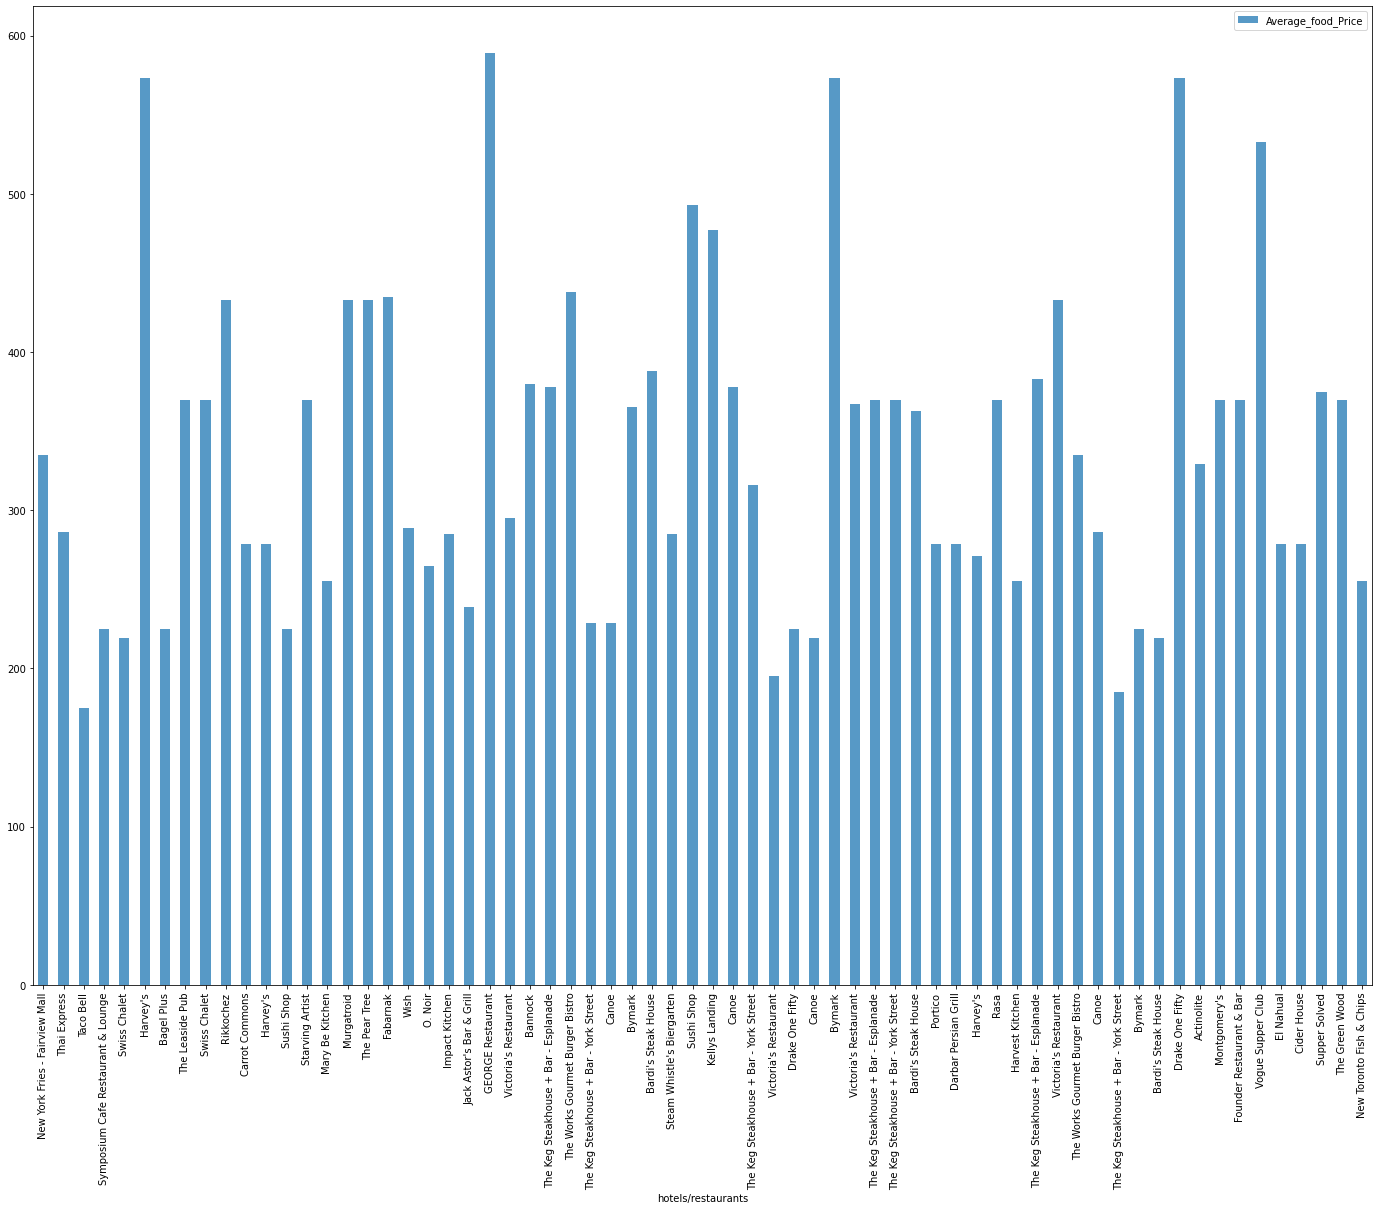

In [53]:
scarborough_Avg_hotelprice.plot(kind='bar',figsize=(24,18),alpha=0.75)

In [54]:
Scarborough_hotel_ratings=pd.DataFrame({"hotels/restaurants":df_hotels["Venue"],
                                      "Food Rating":[7.0,9.0,5.0,8.0,10.0,10.0,7.0,10.0,1.0,2.0,
                                                           5.0,4.0,8.0,9.0,9.0,6.0,6.0,4.0,5.0,4.0,
                                                           10.0,2.0,5.0,8.0,9.0,6.0,6.0,10.0,8.0,9.0,
                                                           1.0,2.0,3.0,4.0,5.0,6.0,9.0,8.0,5.0,9.0,
                                                           6.0,9.0,6.0,4.0,8.0,10.0,2.0,5.0,6.0,3.0,
                                                           9.0,8.0,7.0,7.0,8.0,5.0,8.0,9.0,1.0,5.0,
                                                           4.0,7.0,2.0,3.0,6.0,6.0]})
#all ratings are assumed ratings, it is not a real data.

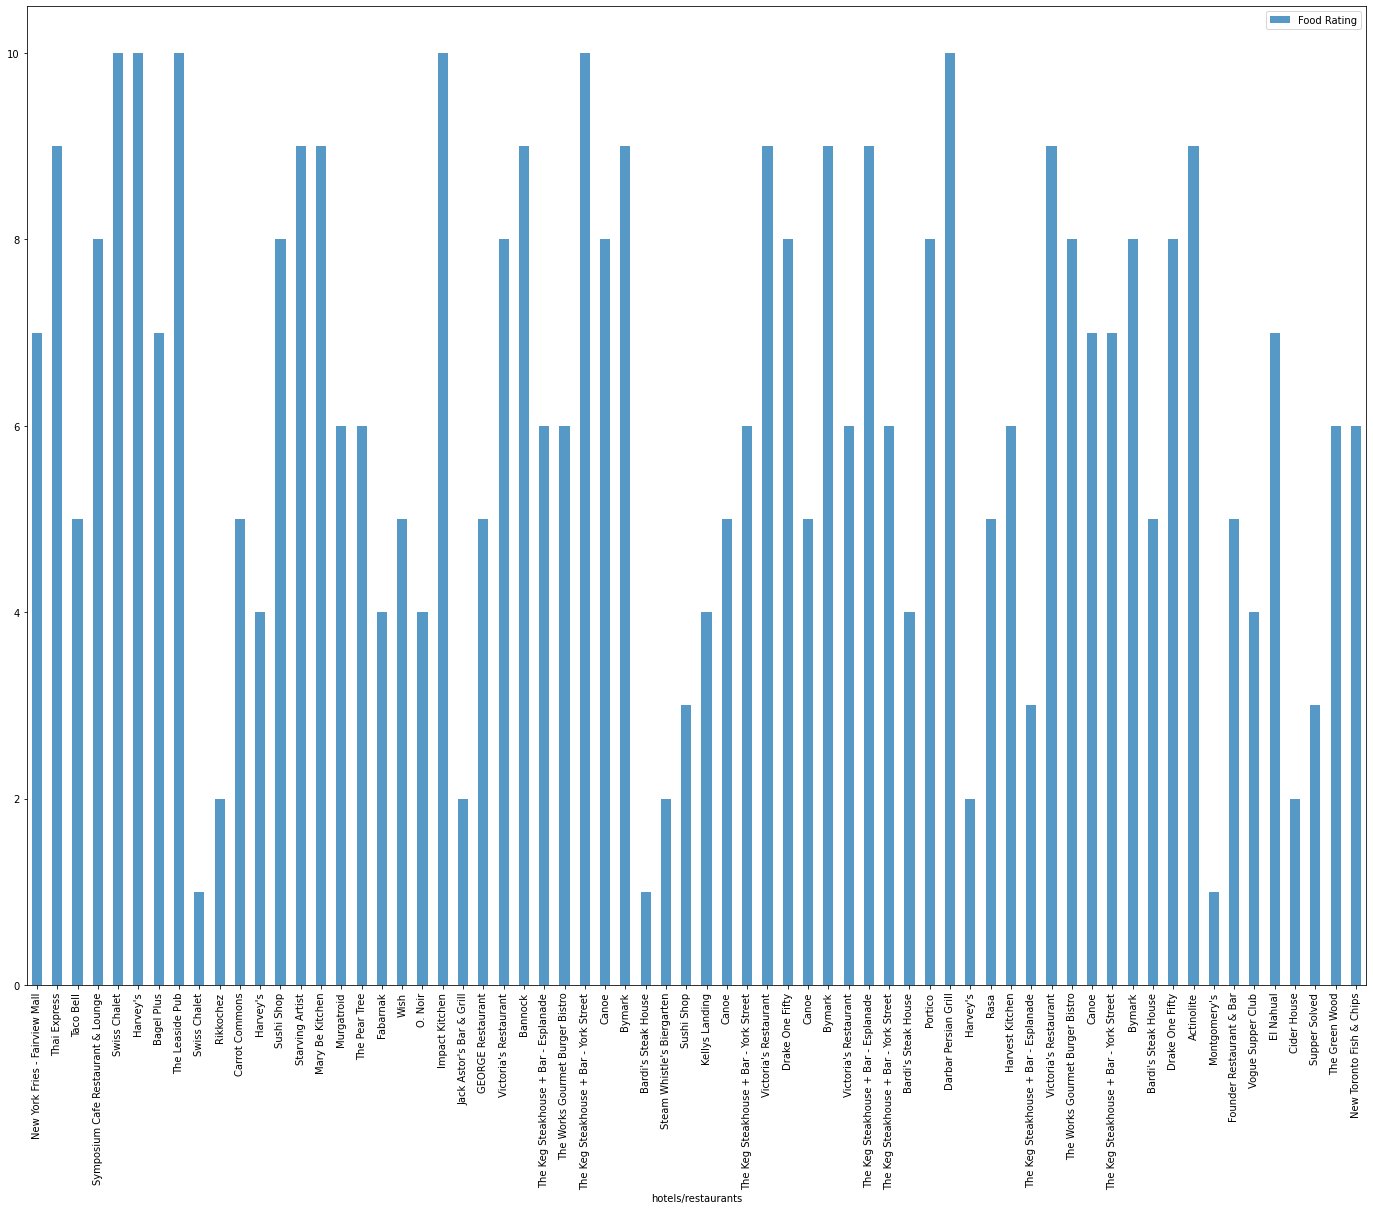

In [55]:
Scarborough_hotel_ratings.set_index("hotels/restaurants",inplace=True,drop=True)
Scarborough_hotel_ratings.plot(kind='bar',figsize=(24,18),alpha=0.75)

In [56]:
price_best=pd.DataFrame(scarborough_Avg_hotelprice['Average_food_Price'].sort_values())
price_best.reset_index(inplace=True)

In [57]:
ratings_best=pd.DataFrame(Scarborough_hotel_ratings['Food Rating'].sort_values(ascending=False))
ratings_best.reset_index(inplace=True)


In [70]:
price_blist=[]
for i,j in zip(ratings_best['Food Rating'],ratings_best['hotels/restaurants']):
  if i>7:
    price_blist.append(j)
len(price_blist)

25

In [71]:
rating_blist=[]
for i,j in zip(price_best['Average_food_Price'],price_best['hotels/restaurants']):
  if i>price_best['Average_food_Price'].mean():
    rating_blist.append(j)
len(rating_blist)

31

In [78]:
df_price=price_best[price_best['Average_food_Price']<price_best['Average_food_Price'].mean()]
df_price

,hotels/restaurants,Average_food_Price
0,Taco Bell,175.0
1,The Keg Steakhouse + Bar - York Street,185.0
2,Victoria's Restaurant,195.0
3,Swiss Chalet,219.0
4,Bardi's Steak House,219.0
5,Canoe,219.0
6,Bymark,225.0
7,Symposium Cafe Restaurant & Lounge,225.0
8,Bagel Plus,225.0
9,Drake One Fifty,225.0


In [79]:
df_rate=ratings_best[ratings_best['Food Rating']>7]
df_rate

,hotels/restaurants,Food Rating
0,The Keg Steakhouse + Bar - York Street,10.0
1,Swiss Chalet,10.0
2,Harvey's,10.0
3,Impact Kitchen,10.0
4,Darbar Persian Grill,10.0
5,The Leaside Pub,10.0
6,Starving Artist,9.0
7,Bymark,9.0
8,Bymark,9.0
9,Victoria's Restaurant,9.0


In [83]:
df_final=df_rate.merge(df_price,on='hotels/restaurants')
df_final

,hotels/restaurants,Food Rating,Average_food_Price
0,The Keg Steakhouse + Bar - York Street,10.0,185.0
1,The Keg Steakhouse + Bar - York Street,10.0,229.0
2,The Keg Steakhouse + Bar - York Street,10.0,316.0
3,Swiss Chalet,10.0,219.0
4,Harvey's,10.0,271.0
5,Harvey's,10.0,279.0
6,Impact Kitchen,10.0,285.0
7,Darbar Persian Grill,10.0,279.0
8,Bymark,9.0,225.0
9,Bymark,9.0,225.0


<h1><b>From the above table we can identify the best <u><i>hotels/restaurants</i></u> are:</b>

1. The Keg Steakhouse + Bar - York Street	
2.Swiss Chalet   
3.Harvey's   
4.Impact Kitchen    
5.Darbar Persian Grill    
6.Bymark  
7.Victoria's Restaurant     
8.Actinolite   
9.Thai Express    
10.Mary Be Kitchen   
11.Drake One Fifty     
12.Portico   
13.Canoe	  
14.Sushi Shop    
15.The Works Gourmet Burger Bistro   
16.Symposium Cafe Restaurant & Lounge	
<h1>
